In [587]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np
import math

In [588]:
class Event:
    def __init__(self, time, customer_id, assigned_server_id, type):
        self.time = time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.type = type
    
    def __lt__(self, other):
        return self.time < other.time

    def __repr__(self):
        return f'(event_time: {self.time}, customer_id: {self.customer_id}, assigned_server_id: {self.assigned_server_id}, {self.type})'

In [589]:
class Customer:
    def __init__(self, arrival_time, customer_id, assigned_server_id, event_type):
        self.arrival_time = arrival_time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.event_type = event_type
    
    def __repr__(self):
        return f'(customer_time: {self.arrival_time}, customer_id: {self.customer_id}, assigned_server_id: {self.assigned_server_id}, {self.event_type})'

In [590]:
class Server:
    def __init__(self, server_id, service_time, is_busy, busy_until, current_load, total_load):
        self.server_id = server_id
        self.service_time = service_time
        self.is_busy = is_busy
        self.busy_until = busy_until
        self.current_load = current_load
        self.total_load = total_load
    
    def start_serving(self, time):
        self.is_busy = True
        departure_time = time + self.service_time                    
        self.busy_until = departure_time

    def release_server(self):
        self.is_busy = False
        self.busy_until = None
        self.current_load -= 1
    
    def __repr__(self):
        return f'(server_id: {self.server_id}, service_time: {self.service_time}, is_busy: {self.is_busy}, busy_until: {self.busy_until}, cur_load: {self.current_load}, {self.total_load})'

In [596]:
class Simulation:
    def __init__(self, interarrival_time, servers, num_servers, num_customers):
        #self.arrival_rate = arrival_rate
        #self.service_rate = service_rate
        self.interarrival_time = interarrival_time
        self.servers = servers
        self.num_servers = num_servers
        self.num_customers = num_customers
        self.customers = 0
        self.event_queue = []
        self.waiting_queue = []
        self.total_time_spent = 0
        self.max_time_spent = 0
        self.busy_servers = 0 
        self.queue_size = [0]
        self.xd = [0] * num_servers
        self.departures = 0
        self.events = 0

    #def get_interarrival_time(self):
    #    return random.expovariate(1.0 / self.arrival_rate)

    #def get_service_time(self):
    #    return random.expovariate(1.0 / self.service_rate)
    
    def schedule_new_event(self, time, customer_id, assigned_server_id, type):
        heapq.heappush(self.event_queue, Event(time, customer_id, assigned_server_id, type))

    #def initialize_servers_speeds(self, servers_speed):
    #    if servers_speed == 'same':
    #        service = self.get_service_time()
    #        self.servers = [Server(i, service, False, None, 0, 0) for i in range(self.num_servers)]
    #    elif servers_speed == 'different':
    #        self.servers = [Server(i, self.get_service_time(), False, None, 0, 0) for i in range(self.num_servers)]
    
    def select_server_uniformly(self):
        server = random.choice(self.servers)
        self.xd[server.server_id] += 1
        return server
    
    def select_server_uniformly_with_power_of_d_choices(self, d_choices, servers_speed):
        d_servers = random.sample(self.servers, d_choices)
        #print('d_servers', d_servers)
        minimum_load = min(server.current_load for server in d_servers)
        #print('min_server_load', minimum_load)
        servers_with_equal_load = [server for server in d_servers if server.current_load == minimum_load]
        #print('servers_with_equal_min_load', servers_with_equal_load)
        if servers_speed == 'different':
            # Take the fastest server when servers load is equal
            fastest_from_equal_load = [server for server in servers_with_equal_load if server.service_time == min(server.service_time for server in servers_with_equal_load)]
            return fastest_from_equal_load[0]
        else:
            return random.choice(servers_with_equal_load)
            # Try choose first from list server_with_equal_load\n"
        #server = random.choice(servers_with_equal_load)
        #self.xd[server.server_id] += 1
        #return server
        # Try choose first from list server_with_equal_load

    def run(self, d_choices, scenario, servers_speed, ):
        self.schedule_new_event(0, 0, None, 'arrival')
        #interarrival_time = self.get_interarrival_time()
        #self.initialize_servers_speeds(servers_speed)

        #def log(*values):
        #    if debug:
        #        print(*values)
   
        while self.event_queue:
            event = heapq.heappop(self.event_queue) # time, customer_id, assigned_server_id, type
            #print()
            #print('POP_event', event)
            #print('event_queue', self.event_queue)

            if event.type == 'arrival':
                self.customers += 1

                if self.customers < self.num_customers:
                    # Schedule next customer arrival
                    self.schedule_new_event(event.time + self.interarrival_time, event.customer_id + 1, None, 'arrival')
                    #print('event_queue_schedule_new_arrival', self.event_queue)
                
                if scenario == 'uniform server selection':
                    choosen_server = self.select_server_uniformly()
                    #print('XD')
                
                elif scenario == 'uniform server selection with power of d-choices':
                    choosen_server = self.select_server_uniformly_with_power_of_d_choices(d_choices, servers_speed)
                    #print('choosen_server, random_choice_from_list', choosen_server)
                else:
                    raise Exception('Unknown scenario')

                choosen_server.current_load += 1
                choosen_server.total_load += 1
                #print('server_current_loads', choosen_server)

                if not choosen_server.is_busy:
                    #print('if server is not busy')
                    choosen_server.start_serving(event.time)
                    #print('server_start_serving', choosen_server)                   
                    self.total_time_spent += choosen_server.service_time
                    #print('total_time_spent', self.total_time_spent)
                    self.max_time_spent = max(self.max_time_spent, choosen_server.service_time)
                    # Schedule the departure event for the customer
                    self.schedule_new_event(choosen_server.busy_until, event.customer_id, choosen_server.server_id, 'departure')
                    #print('event_queue_schedule_departure', self.event_queue)
                else:
                    # If the chosen server is busy, add a customer to the waiting queue
                    #print('chosen server is busy, add a customer to the waiting queue')
                    customer = Customer(event.time, event.customer_id, choosen_server.server_id, event.type)
                    self.waiting_queue.append(customer)
                    #print('waiting_queue', self.waiting_queue)
                    busy_servers = sum(server.is_busy for server in self.servers)
                    self.queue_size.append(len(self.waiting_queue))  
            
            elif event.type == 'departure': 
                server = self.servers[event.assigned_server_id]
                #print('departure_server', server)
                server.release_server()
                self.departures += 1
                #print('server_after_release', server)

                # If for this server is assigned customer in waiting_queue, start serving first from the list
                #print('if for this server is assigned customer in waiting_queue, start serving first from the list')
                #print('waiting_queue', self.waiting_queue)
                for waiting_customer in self.waiting_queue:
                    if waiting_customer.assigned_server_id == event.assigned_server_id:
                        server.start_serving(event.time)
                        #print('server_after_start_serving', server)
                        waiting_time = event.time - waiting_customer.arrival_time
                        #print(f'waiting_time = event.time {event.time} - waiting_customer.time {waiting_customer.arrival_time}')
                        time_spent = waiting_time + server.service_time
                        #print(f'time_spent = waiting_time {waiting_time} + server.service_time {server.service_time}')
                        #print('curr_total_time_spent', self.total_time_spent)
                        self.total_time_spent += time_spent
                        #print('total_time_spent', self.total_time_spent)
                        self.max_time_spent = max(self.max_time_spent, time_spent)
                        # Schedule the departure event for the customer
                        self.schedule_new_event(server.busy_until, event.customer_id, event.assigned_server_id, 'departure')
                        #print('event_queue_schedule_departure', self.event_queue)
                        # Remove customer from the waiting queue
                        self.waiting_queue.remove(waiting_customer)
                        #print('waiting_queue_remove_waiting_customer', self.waiting_queue)
                        break   

        avg_time_spent = (self.total_time_spent) / (self.customers)
        server_utilization = [round((server.total_load / self.customers) * 100, 4) for server in self.servers]
        max_load = max(server.total_load for server in self.servers)
        avg_queue_size = np.mean(self.queue_size)
        total_load_1 = [server.total_load for server in self.servers]

        return avg_time_spent, self.max_time_spent, server_utilization, avg_queue_size, max_load

        #print('Average time a customer spends in the system: ', avg_time_spent)
        #print('Max time a customer spends in the system: ', self.max_time_spent)
        #print('Percentage servers utilization: ', server_utilization)
        #print('Average queue size: ', avg_queue_size)


In [597]:
def get_interarrival_time(arrival_rate):
    return random.expovariate(1.0 / arrival_rate)

def get_service_time(service_rate):
    return random.expovariate(1.0 / service_rate)

def initialize_servers(service_time, service_rate, num_servers, servers_speed):
    if servers_speed == 'same':
        return [Server(i, service_time, False, None, 0, 0) for i in range(num_servers)]
    elif servers_speed == 'different':
        return [Server(i, get_service_time(service_rate), False, None, 0, 0) for i in range(num_servers)]

In [598]:
def experiment(params):
    arrival_rate = 1.0
    service_rate = 1.0
    num_servers = 10
    num_customers = 10000
    servers_speed = 'different'
    num_experiments = 100

    data = {'avg_time_spent': [], 'max_time_spent': [], 'server_utilization': [], 'avg_queue_size': [], 'max_load':[], 'server_speed_to_load': []}

    interarrival_times = []
    service_times = []
    for _ in range(0, num_experiments):
        interarrival_times.append(get_interarrival_time(arrival_rate))
        service_times.append(get_service_time(service_rate))

    for i in range(0, num_experiments):
        servers = initialize_servers(service_times[i], service_rate, num_servers, servers_speed)

        simulation = Simulation(interarrival_times[i], servers, num_servers, num_customers)
        avg_time_spent, max_time_spent, server_utilization, avg_queue_size, max_load = simulation.run(params["d_choices"], params["scenario"], servers_speed)
        data['avg_time_spent'].append(avg_time_spent)
        data['max_time_spent'].append(max_time_spent)
        data['server_utilization'].append(server_utilization)
        data['avg_queue_size'].append(avg_queue_size)
        data['max_load'].append(max_load)
        data['server_speed_to_load'].extend(
            list(zip(
                [s.service_time for s in servers],
                server_utilization
            ))
        )

    data['server_speed_to_load'].sort(key=lambda x: x[0])

    return data

In [599]:
random.seed(0)
data = experiment({
    'scenario': 'uniform server selection',
    'd_choices': 0,
})

random.seed(0)
data_1 = experiment({
    'scenario': 'uniform server selection with power of d-choices',
    'd_choices': 2
})

In [595]:
print(data['server_speed_to_load'])
print(data_1['server_speed_to_load'])

[(0.0006939244849712196, 10.280000000000001), (0.0019668598223836257, 10.08), (0.0024582228608797394, 10.33), (0.002636891102961678, 9.6), (0.0034787897369633904, 10.9), (0.003952784507282727, 9.629999999999999), (0.004373949595914539, 10.05), (0.004750029483772075, 10.39), (0.004858915076420195, 9.629999999999999), (0.005694897397010441, 9.44), (0.005841853662544049, 10.07), (0.006618901016506362, 10.02), (0.008154537517832574, 10.25), (0.008256046179193243, 9.62), (0.008538267056891006, 10.100000000000001), (0.00858128707104653, 9.89), (0.011055789981935231, 10.100000000000001), (0.012247549815335325, 9.969999999999999), (0.012383253137131314, 10.32), (0.014379005847185683, 10.27), (0.015477761132389174, 10.01), (0.017613068786089123, 10.51), (0.02336823216988862, 9.969999999999999), (0.025670181370487804, 9.71), (0.02569680939796043, 10.47), (0.027423324719801155, 10.31), (0.02748812682596978, 10.33), (0.02793466585538387, 10.32), (0.029525737782613446, 10.24), (0.02998284704686402,

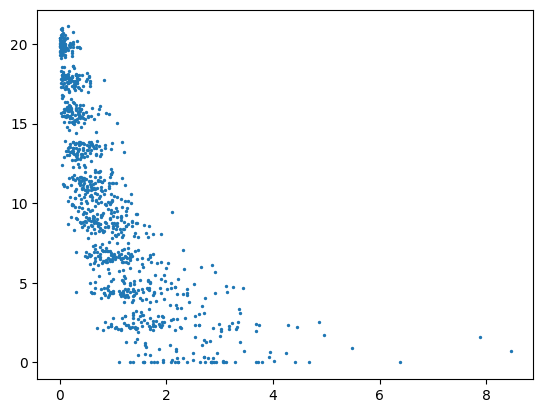

In [600]:
plt.scatter(*zip(*data_1['server_speed_to_load']), s=2)

In [605]:
def plot():
    plt.plot(data['avg_time_spent'])
    plt.plot(data_1['avg_time_spent'])

    mean_avg_time_spent = np.mean(data['avg_time_spent'])
    mean_max_time_spent = np.mean(data['max_time_spent'])
    mean_avg_queue_size = np.mean(data['avg_queue_size'])
    #server_utilization = np.mean(data['max_load'])
    
    mean_avg_time_spent_1 = np.mean(data_1['avg_time_spent'])
    mean_avg_queue_size_1 = np.mean(data_1['avg_queue_size'])
    mean_max_time_spent_1 = np.mean(data_1['max_time_spent'])
    # mean_max_load_1 = np.mean(data_1['max_load'])
    

    print('mean_avg_time_spent', mean_avg_time_spent)
    print('mean_avg_queue_size', mean_avg_queue_size)
    print('mean_max_time_spent', mean_max_time_spent)
    print()

    print('mean_avg_time_spent_1', mean_avg_time_spent_1)
    print('mean_avg_queue_size_1', mean_avg_queue_size_1)
    print('mean_max_time_spent_1', mean_max_time_spent_1)

mean_avg_time_spent 46.66149110346864
mean_avg_queue_size 262.3824097998403
mean_max_time_spent 417.9889295579269

mean_avg_time_spent_1 10.891918565567874
mean_avg_queue_size_1 143.7704448132747
mean_max_time_spent_1 61.94775546205838


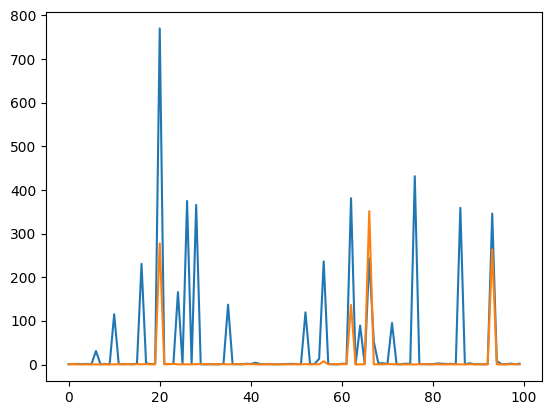

In [606]:
plot()

In [267]:
def plot(data):

    for arrival_rate in [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]:
        #sorted_idx = sorted(list(range(0, len(data[arrival_rate]['avg_time_spent']))), key=lambda i: data[arrival_rate]['avg_time_spent'][i], reverse=True)
        for i in range(0, 10000, 10):
            #plt.plot(data[arrival_rate]['avg_time_spent'][sorted_idx[i]])
            plt.plot(data[arrival_rate]['avg_time_spent'])

        mean_avg_time_spent = np.mean(data[arrival_rate]['avg_time_spent'])
        mean_avg_queue_size = np.mean(data[arrival_rate]['avg_queue_size'])
        mean_max_load = np.mean(data[arrival_rate]['max_load'])

    #plt.show()
    print('mean_avg_time_spent', mean_avg_time_spent)
    print('mean_avg_queue_size', mean_avg_queue_size)
    print('mean_max_load', mean_max_load)


# Pierwszy scenariusz

### Identyczne serwery i zadania

#### a) jednostajny wybór serwera

In [268]:
data = experiment(d_choices=0, scenario='uniform server selection', servers_speed='same')

In [269]:
plot(data)

KeyError: 0.7

Error in callback <function flush_figures at 0x000001A1255A8700> (for post_execute):


KeyboardInterrupt: 

In [60]:
plot(experiment(d_choices=False, scenario='uniform server selection', servers_speed='same'))

TypeError: initialize_servers_speeds() got an unexpected keyword argument 'servers_rate'

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

mean_avg_time_spent 2.579543142378132
mean_avg_queue_size 1.2311956517109488
mean_max_load 122.785


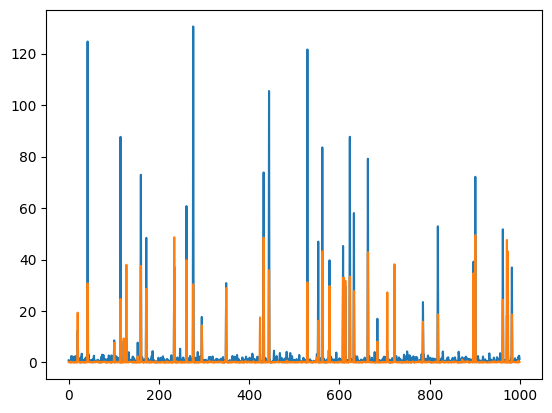

In [ ]:
plot(experiment(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='same'))

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

In [ ]:
same_speeds_3_choices = experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='same')

mean_avg_time_spent 2.1883936599868594
mean_avg_queue_size 1.0004780104574647


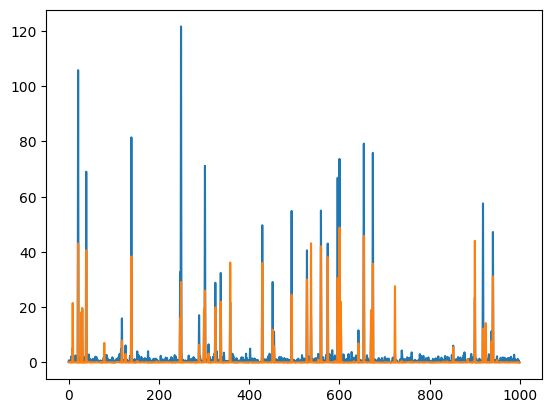

In [ ]:
plot(same_speeds_3_choices)

# Drugi scenariusz

### Serwery o różnej szybkości, takie same zadania

#### a) jednostajny wybór serwera

In [ ]:
different_servers_uniform_choice = experiment(d_choices=False, scenario='uniform server selection', servers_speed='different')

mean_avg_time_spent 2.5721575238612258
mean_avg_queue_size 1.882056464671077


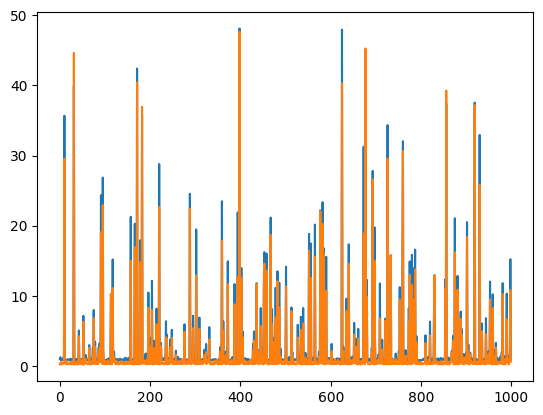

In [ ]:
plot(different_servers_uniform_choice)

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

In [ ]:
different_servers_2_choices = experiment(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='different')

mean_avg_time_spent 0.7311838693043273
mean_avg_queue_size 0.6153893307721228


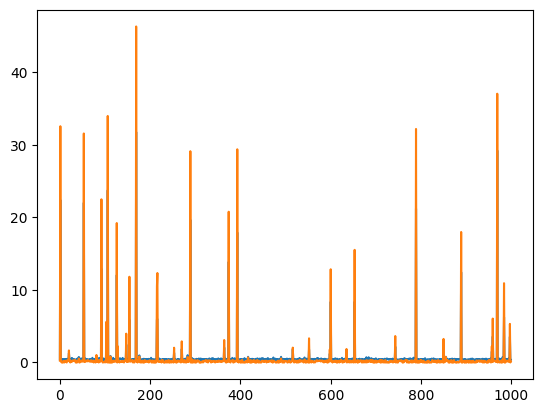

In [ ]:
plot(different_servers_2_choices)

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

mean_avg_time_spent 0.41094670807312256
mean_avg_queue_size 0.20623101064012975


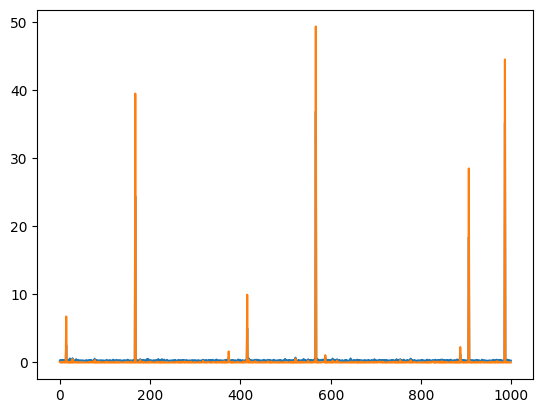

In [ ]:
plot(experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='different'))

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów

# Trzeci scenariusz

### Serwery o różnej szybkości, różne zadania

#### a) jednostajny wybór serwera

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów